## Langkah 1: Download Dataset ikan/fish
### Mengambil subset dataset Open Images V7 yang hanya berisi objek variabel "fish" dengan bounding box.
1. Filter dengan class **Fish**
2. Tipe labelnya **detections**

In [ ]:
# Step 1: Install the necessary library
# !pip install fiftyone

import fiftyone as fo
import fiftyone.zoo as foz

# Step 2: Download a subset of Open Images V7
# We'll load 500 samples from the 'validation' split that have 'detections' for the 'Fish' class.
dataset = foz.load_zoo_dataset(
    "open-images-v7",
    split="validation",           # Can also use "train" or "test"
    label_types=["detections"],   # We need bounding boxes
    classes=["Fish"],             # Filter for your target class
    max_samples=5000,              # Limit size for manageability
    # dataset_dir="open_images_fish", # Directory to save data
    shuffle=True
)


## Langkah 2: Diagnosis Dataset dan cropping bounding box
1. Memastikan dataset **Fish** benar-benar berisi dataset ikan dan tau di field mana.
2. Mencrop setiap bounding box "**Fish** menjadi gambar kecil
3. Membagi menjadi train/val dan memverifikasi hasilnya

MEMULAI PROSES PREPARASI DATASET IKAN
🗑️  Menghapus dataset lama 'fish-detection-dataset'...

📥 Mengunduh dan memuat dataset Open Images V7 (hanya kelas 'Fish')...
Only found 356 (<5000) samples matching your requirements
Necessary images already downloaded
Existing download of split 'validation' is sufficient
Loading 'open-images-v7' split 'validation'
 100% |█████████████████| 356/356 [1.1s elapsed, 0s remaining, 339.5 samples/s]         
Dataset 'fish-detection-dataset' created
✅ Dataset 'fish-detection-dataset' berhasil dimuat!
   📊 Jumlah sampel: 356

DIAGNOSIS STRUKTUR DATASET
🔍 Field yang tersedia pada sampel pertama:
   - 'id': str
   - 'filepath': str
   - 'tags': BaseList
   - 'metadata': NoneType
   - 'created_at': datetime
   - 'last_modified_at': datetime
   - 'ground_truth': Detections
      Tipe: <class 'fiftyone.core.labels.Detections'>

🔎 Mencari field yang berisi deteksi...
   Field 'ground_truth': <class 'fiftyone.core.labels.Detections'>
      ✅ Ditemukan 12 deteksi

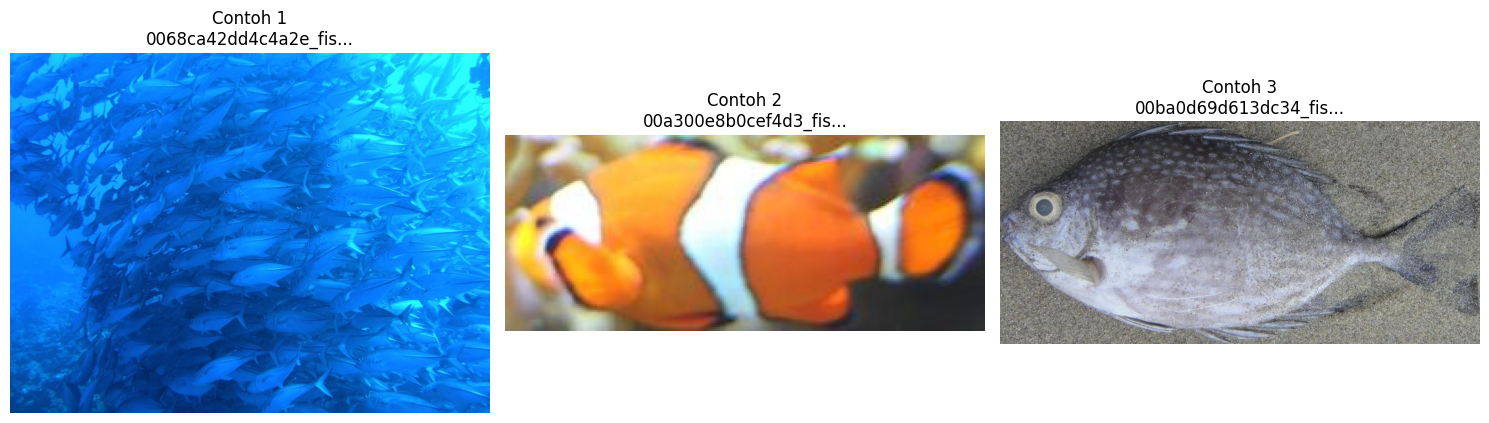


PROSES SELESAI

💾 Informasi dataset disimpan di: ./fish_crops\dataset_info.txt


In [1]:
import os
from PIL import Image
import numpy as np
import fiftyone as fo
import fiftyone.zoo as foz
import pandas as pd

print("=" * 70)
print("MEMULAI PROSES PREPARASI DATASET IKAN")
print("=" * 70)

# ---- BAGIAN 1: HAPUS DAN MUAT ULANG DATASET DENGAN KONFIGURASI TEPAT ----
dataset_name = "fish-detection-dataset"

# Hapus dataset lama jika ada
if dataset_name in fo.list_datasets():
    print(f"🗑️  Menghapus dataset lama '{dataset_name}'...")
    fo.delete_dataset(dataset_name)

print("\n📥 Mengunduh dan memuat dataset Open Images V7 (hanya kelas 'Fish')...")

# Muat dataset dengan konfigurasi yang lebih eksplisit
dataset = foz.load_zoo_dataset(
    "open-images-v7",
    split="validation",
    label_types=["detections"],
    classes=["Fish"],
    max_samples=5000,
    shuffle=True,
    dataset_name=dataset_name,
    only_matching=True,  # Hanya menyertakan gambar yang memiliki deteksi 'Fish'
    seed=42
)

print(f"✅ Dataset '{dataset.name}' berhasil dimuat!")
print(f"   📊 Jumlah sampel: {len(dataset)}")

# ---- BAGIAN 2: DIAGNOSIS STRUKTUR DATASET ----
print("\n" + "=" * 70)
print("DIAGNOSIS STRUKTUR DATASET")
print("=" * 70)

if len(dataset) > 0:
    sample = dataset.first()
    
    print("🔍 Field yang tersedia pada sampel pertama:")
    for field_name in sample.field_names:
        field_value = sample[field_name]
        print(f"   - '{field_name}': {type(field_value).__name__}")
        
        # Tampilkan detail untuk field yang penting
        if field_name == "detections" and field_value is not None:
            print(f"      Jumlah deteksi: {len(field_value.detections)}")
            for i, det in enumerate(field_value.detections[:3]):  # Tampilkan 3 pertama
                print(f"      Deteksi {i+1}: Label='{det.label}', BBox={det.bounding_box}")
        elif field_name == "ground_truth" and field_value is not None:
            print(f"      Tipe: {type(field_value)}")
    
    # Cek apakah ada deteksi dengan cara lain
    print("\n🔎 Mencari field yang berisi deteksi...")
    
    # Coba cari field yang mungkin berisi deteksi
    possible_detection_fields = ["detections", "ground_truth", "objects", "labels"]
    found_detections = False
    
    for field in possible_detection_fields:
        if field in sample.field_names:
            field_value = sample[field]
            print(f"   Field '{field}': {type(field_value)}")
            
            # Coba akses deteksi
            try:
                if hasattr(field_value, 'detections'):
                    detections = field_value.detections
                    if len(detections) > 0:
                        print(f"      ✅ Ditemukan {len(detections)} deteksi!")
                        print(f"      Contoh: Label='{detections[0].label}'")
                        found_detections = True
                        break
            except:
                pass
    
    if not found_detections:
        print("   ⚠️  Tidak ditemukan field deteksi yang dapat diakses.")
        print("   ℹ️  Akan mencoba pendekatan alternatif...")

# ---- BAGIAN 3: PROSES CROPPING DENGAN PENANGANAN MULTI-SKENARIO ----
print("\n" + "=" * 70)
print("PROSES CROPPING GAMBAR IKAN")
print("=" * 70)

# 1. Siapkan struktur folder
base_crop_dir = "./fish_crops"
train_dir = os.path.join(base_crop_dir, "train")
val_dir = os.path.join(base_crop_dir, "val")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# 2. Parameter
split_ratio = 0.8
np.random.seed(42)
image_count = 0
problem_count = 0

print(f"🎯 Target folder: {base_crop_dir}")
print(f"📁 Train: {train_dir}")
print(f"📁 Val: {val_dir}")

# 3. Fungsi untuk mendapatkan deteksi dari sampel
def get_detections_from_sample(sample):
    """Mencoba berbagai cara untuk mendapatkan deteksi dari sampel."""
    
    # Coba field 'detections' langsung
    if "detections" in sample.field_names:
        detections_field = sample["detections"]
        if detections_field is not None and hasattr(detections_field, 'detections'):
            return detections_field.detections
    
    # Coba field 'ground_truth'
    if "ground_truth" in sample.field_names:
        gt_field = sample["ground_truth"]
        if gt_field is not None and hasattr(gt_field, 'detections'):
            return gt_field.detections
    
    # Coba field lain yang mungkin
    for field_name in sample.field_names:
        field_value = sample[field_name]
        if field_value is not None and hasattr(field_value, 'detections'):
            return field_value.detections
    
    return None

# 4. Proses cropping
print("\n⏳ Memulai proses cropping...")

for idx, sample in enumerate(dataset):
    # Progress update
    if idx % 50 == 0 and idx > 0:
        print(f"   📊 Progress: {idx}/{len(dataset)} gambar, {image_count} ikan berhasil dicrop")
    
    try:
        # Buka gambar
        img_path = sample.filepath
        if not os.path.exists(img_path):
            problem_count += 1
            continue
        
        img = Image.open(img_path).convert("RGB")
        img_width, img_height = img.size
        
        # Dapatkan deteksi
        detections = get_detections_from_sample(sample)
        
        if detections is None or len(detections) == 0:
            # Gambar ini tidak memiliki deteksi ikan
            continue
        
        # Proses setiap deteksi
        for detection in detections:
            # Pastikan ini deteksi ikan
            if hasattr(detection, 'label') and detection.label == "Fish":
                # Dapatkan bounding box
                if not hasattr(detection, 'bounding_box'):
                    continue
                
                bbox = detection.bounding_box
                if len(bbox) != 4:
                    continue
                
                # Konversi ke koordinat pixel
                x_min_norm, y_min_norm, width_norm, height_norm = bbox
                x_min = int(x_min_norm * img_width)
                y_min = int(y_min_norm * img_height)
                x_max = int((x_min_norm + width_norm) * img_width)
                y_max = int((y_min_norm + height_norm) * img_height)
                
                # Validasi ukuran bounding box
                if (x_max - x_min) < 20 or (y_max - y_min) < 20:
                    continue
                
                # Pastikan dalam batas gambar
                x_min = max(0, x_min)
                y_min = max(0, y_min)
                x_max = min(img_width, x_max)
                y_max = min(img_height, y_max)
                
                if x_min >= x_max or y_min >= y_max:
                    continue
                
                # Crop gambar
                try:
                    cropped_img = img.crop((x_min, y_min, x_max, y_max))
                    
                    # Tentukan folder penyimpanan
                    save_dir = train_dir if np.random.random() < split_ratio else val_dir
                    
                    # Buat nama file
                    base_name = os.path.basename(img_path).split('.')[0]
                    filename = f"{base_name}_fish_{image_count:06d}.jpg"
                    save_path = os.path.join(save_dir, filename)
                    
                    # Simpan gambar
                    cropped_img.save(save_path)
                    image_count += 1
                    
                except Exception as crop_error:
                    problem_count += 1
                    if problem_count <= 3:
                        print(f"    ⚠️  Gagal crop: {str(crop_error)[:50]}...")
    
    except Exception as e:
        problem_count += 1
        if problem_count <= 5:
            print(f"    ⚠️  Error memproses {os.path.basename(sample.filepath)}: {str(e)[:50]}...")

# ---- BAGIAN 4: HASIL DAN VERIFIKASI ----
print("\n" + "=" * 70)
print("HASIL PROSES CROPPING")
print("=" * 70)

print(f"\n📊 STATISTIK:")
print(f"   ✅ Gambar ikan berhasil dicrop: {image_count}")
print(f"   ⚠️  Masalah yang ditemui: {problem_count}")
print(f"   📁 Folder train: {train_dir} ({len(os.listdir(train_dir))} file)")
print(f"   📁 Folder val: {val_dir} ({len(os.listdir(val_dir))} file)")

# Verifikasi dengan menampilkan beberapa hasil
print("\n🔍 VERIFIKASI VISUAL:")

# Cek apakah ada file yang berhasil disimpan
all_files = []
for folder in [train_dir, val_dir]:
    if os.path.exists(folder):
        files = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        all_files.extend([(folder, f) for f in files])

if len(all_files) > 0:
    print(f"   Ditemukan {len(all_files)} file gambar.")
    
    # Tampilkan 3 gambar pertama
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, min(3, len(all_files)), figsize=(15, 5))
    
    if min(3, len(all_files)) == 1:
        axes = [axes]
    
    for i, (folder, filename) in enumerate(all_files[:3]):
        try:
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path)
            
            axes[i].imshow(img)
            axes[i].set_title(f"Contoh {i+1}\n{filename[:20]}...")
            axes[i].axis('off')
            img.close()
            
            # Tampilkan info ukuran
            print(f"   Contoh {i+1}: {filename} ({img.size[0]}x{img.size[1]} px)")
        except Exception as e:
            axes[i].text(0.5, 0.5, "Gagal\nmemuat", ha='center', va='center')
            axes[i].set_title(f"Contoh {i+1}\n(Error)")
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("   ⚠️  Tidak ada file gambar yang ditemukan.")
    
    # Diagnosa lebih lanjut
    print("\n🔧 DIAGNOSA LANJUT:")
    print("   Kemungkinan masalah:")
    print("   1. Dataset tidak memiliki deteksi 'Fish'")
    print("   2. Field deteksi tidak dapat diakses")
    print("   3. Bounding box tidak valid")
    
    # Coba analisis deteksi
    if len(dataset) > 0:
        sample = dataset.first()
        print(f"\n   Contoh sampel pertama:")
        print(f"   - Path: {sample.filepath}")
        
        # Hitung total deteksi di seluruh dataset
        total_detections = 0
        fish_detections = 0
        
        for i, samp in enumerate(dataset):
            dets = get_detections_from_sample(samp)
            if dets:
                total_detections += len(dets)
                for det in dets:
                    if hasattr(det, 'label') and det.label == "Fish":
                        fish_detections += 1
            
            if i >= 10:  # Cek 10 sampel pertama saja
                break
        
        print(f"   - Deteksi total (10 sampel pertama): {total_detections}")
        print(f"   - Deteksi 'Fish' (10 sampel pertama): {fish_detections}")

print("\n" + "=" * 70)
print("PROSES SELESAI")
print("=" * 70)

# Simpan informasi dataset ke file
if image_count > 0:
    info_file = os.path.join(base_crop_dir, "dataset_info.txt")
    with open(info_file, 'w') as f:
        f.write(f"Dataset Ikan - Open Images V7\n")
        f.write(f"Dibuat pada: {pd.Timestamp.now()}\n")
        f.write(f"Jumlah gambar ikan: {image_count}\n")
        f.write(f"Train: {len(os.listdir(train_dir))} file\n")
        f.write(f"Val: {len(os.listdir(val_dir))} file\n")
    
    print(f"\n💾 Informasi dataset disimpan di: {info_file}")

## Langkah 3: Membuat Dataset **Non-Fish**
1. Menyusun folder agar cocok dengan ImageDataGenerator.flow_from_directory: train/fish, train/non_fish, val/fish, val/non_fish
2. Memindahkan semua hasil crop (yang semula ada langsung di **train** dan **val**) ke subfolder **fish**
3. Membuat gambar sistetis **non_fish** (bentuk geometris) dengan jumlah sama untuk menyeimbangkan kelas

MEMPERBAIKI STRUKTUR FOLDER DATASET
✅ Membuat folder: ./fish_crops\train\fish
✅ Membuat folder: ./fish_crops\train\non_fish
✅ Membuat folder: ./fish_crops\val\fish
✅ Membuat folder: ./fish_crops\val\non_fish

📁 Memindahkan gambar ikan ke folder 'fish'...
   ➡️  478 gambar dipindahkan ke ./fish_crops\train\fish
   ➡️  132 gambar dipindahkan ke ./fish_crops\val\fish

📊 Jumlah gambar fish di train: 478
📊 Jumlah gambar fish di val: 132

🎨 Membuat gambar non-fish sintetis...

🔄 Membuat 478 gambar non-fish untuk train...
   Created 50/478...
   Created 100/478...
   Created 150/478...
   Created 200/478...
   Created 250/478...
   Created 300/478...
   Created 350/478...
   Created 400/478...
   Created 450/478...
🔄 Membuat 132 gambar non-fish untuk val...
   Created 20/132...
   Created 40/132...
   Created 60/132...
   Created 80/132...
   Created 100/132...
   Created 120/132...

VERIFIKASI STRUKTUR FOLDER AKHIR
📁 ./fish_crops/
   ├── train/
   │   ├── fish/       → 478 files
   │   └── n

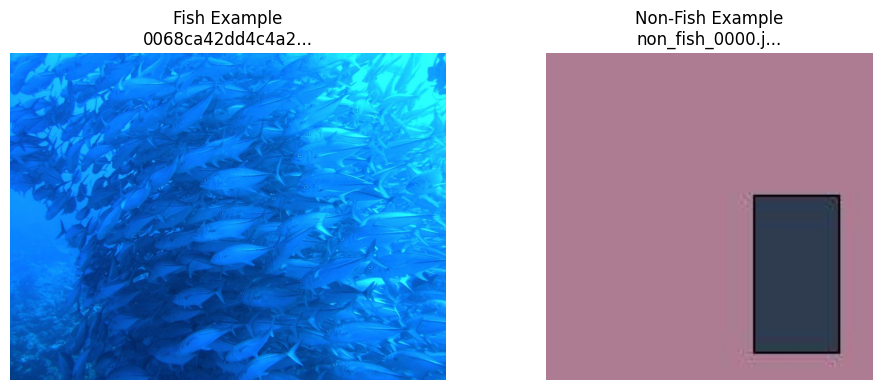


✅ STRUKTUR FOLDER SIAP UNTUK TRAINING!

📋 Struktur yang dihasilkan:
fish_crops/
├── train/
│   ├── fish/        # Gambar ikan asli dari cropping
│   └── non_fish/    # Gambar sintetis (bukan ikan)
└── val/
    ├── fish/        # Gambar ikan asli dari cropping
    └── non_fish/    # Gambar sintetis (bukan ikan)


In [2]:
import os
import shutil
import numpy as np
from PIL import Image, ImageDraw

print("=" * 70)
print("MEMPERBAIKI STRUKTUR FOLDER DATASET")
print("=" * 70)

# 1. Definisikan path
base_dir = "./fish_crops"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")

# 2. Buat subfolder untuk kelas 'fish' dan 'non_fish'
train_fish_dir = os.path.join(train_dir, "fish")
train_non_fish_dir = os.path.join(train_dir, "non_fish")
val_fish_dir = os.path.join(val_dir, "fish")
val_non_fish_dir = os.path.join(val_dir, "non_fish")

# Buat semua folder yang diperlukan
for folder in [train_fish_dir, train_non_fish_dir, val_fish_dir, val_non_fish_dir]:
    os.makedirs(folder, exist_ok=True)
    print(f"✅ Membuat folder: {folder}")

# 3. Pindahkan file .jpg dari root train/ ke train/fish/
print("\n📁 Memindahkan gambar ikan ke folder 'fish'...")

# Untuk folder train
train_files = [f for f in os.listdir(train_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
for filename in train_files:
    src = os.path.join(train_dir, filename)
    dst = os.path.join(train_fish_dir, filename)
    shutil.move(src, dst)
print(f"   ➡️  {len(train_files)} gambar dipindahkan ke {train_fish_dir}")

# Untuk folder val
val_files = [f for f in os.listdir(val_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
for filename in val_files:
    src = os.path.join(val_dir, filename)
    dst = os.path.join(val_fish_dir, filename)
    shutil.move(src, dst)
print(f"   ➡️  {len(val_files)} gambar dipindahkan ke {val_fish_dir}")

# 4. Hitung jumlah gambar ikan
fish_train_count = len([f for f in os.listdir(train_fish_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
fish_val_count = len([f for f in os.listdir(val_fish_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

print(f"\n📊 Jumlah gambar fish di train: {fish_train_count}")
print(f"📊 Jumlah gambar fish di val: {fish_val_count}")

# 5. Buat gambar non-fish sintetis
print("\n🎨 Membuat gambar non-fish sintetis...")

def create_non_fish_image(img_size=(150, 150), idx=0):
    """Membuat gambar geometris sebagai kelas non-fish"""
    # Buat gambar dengan background acak
    img = Image.new('RGB', img_size, color=(
        np.random.randint(100, 200),
        np.random.randint(100, 200),
        np.random.randint(100, 200)
    ))
    draw = ImageDraw.Draw(img)

    # Pilih bentuk geometris acak
    shapes = ['rectangle', 'circle', 'triangle', 'polygon', 'lines']
    shape_type = np.random.choice(shapes)

    if shape_type == 'rectangle':
        # Pastikan x1 > x0 dan y1 > y0
        x0 = np.random.randint(10, img_size[0] - 40)
        y0 = np.random.randint(10, img_size[1] - 40)
        x1 = np.random.randint(x0 + 10, img_size[0] - 10)
        y1 = np.random.randint(y0 + 10, img_size[1] - 10)
        draw.rectangle(
            [x0, y0, x1, y1],
            fill=(
                np.random.randint(0, 255),
                np.random.randint(0, 255),
                np.random.randint(0, 255)
            ),
            outline='black'
        )

    elif shape_type == 'circle':
        # Pastikan x1 > x0 dan y1 > y0 untuk ellipse
        x0 = np.random.randint(10, img_size[0] - 40)
        y0 = np.random.randint(10, img_size[1] - 40)
        x1 = np.random.randint(x0 + 10, img_size[0] - 10)
        y1 = np.random.randint(y0 + 10, img_size[1] - 10)
        draw.ellipse(
            [x0, y0, x1, y1],
            fill=(
                np.random.randint(0, 255),
                np.random.randint(0, 255),
                np.random.randint(0, 255)
            ),
            outline='black'
        )

    elif shape_type == 'triangle':
        draw.polygon(
            [
                (np.random.randint(20, img_size[0] - 20), np.random.randint(20, 40)),
                (np.random.randint(10, 40), np.random.randint(60, img_size[1] - 20)),
                (np.random.randint(60, img_size[0] - 10), np.random.randint(60, img_size[1] - 20))
            ],
            fill=(
                np.random.randint(0, 255),
                np.random.randint(0, 255),
                np.random.randint(0, 255)
            ),
            outline='black'
        )

    elif shape_type == 'polygon':
        # Gambar poligon dengan 5-8 sisi
        sides = np.random.randint(5, 9)
        radius = np.random.randint(20, 40)
        center_x = np.random.randint(radius, img_size[0] - radius)
        center_y = np.random.randint(radius, img_size[1] - radius)

        points = []
        for i in range(sides):
            angle = 2 * np.pi * i / sides
            x = int(center_x + radius * np.cos(angle))
            y = int(center_y + radius * np.sin(angle))
            points.append((x, y))

        draw.polygon(
            points,
            fill=(
                np.random.randint(0, 255),
                np.random.randint(0, 255),
                np.random.randint(0, 255)
            ),
            outline='black'
        )

    elif shape_type == 'lines':
        # Gambar beberapa garis acak
        for _ in range(np.random.randint(3, 8)):
            draw.line(
                [
                    np.random.randint(10, img_size[0] - 10),
                    np.random.randint(10, img_size[1] - 10),
                    np.random.randint(10, img_size[0] - 10),
                    np.random.randint(10, img_size[1] - 10)
                ],
                fill=(
                    np.random.randint(0, 255),
                    np.random.randint(0, 255),
                    np.random.randint(0, 255)
                ),
                width=np.random.randint(1, 4)
            )

    return img

# 6. Buat gambar non-fish (jumlah sama dengan fish)
print(f"\n🔄 Membuat {fish_train_count} gambar non-fish untuk train...")
for i in range(fish_train_count):
    img = create_non_fish_image(img_size=(150, 150), idx=i)
    img.save(os.path.join(train_non_fish_dir, f"non_fish_{i:04d}.jpg"))
    if i % 50 == 0 and i > 0:
        print(f"   Created {i}/{fish_train_count}...")

print(f"🔄 Membuat {fish_val_count} gambar non-fish untuk val...")
for i in range(fish_val_count):
    img = create_non_fish_image(img_size=(150, 150), idx=i)
    img.save(os.path.join(val_non_fish_dir, f"non_fish_{i:04d}.jpg"))
    if i % 20 == 0 and i > 0:
        print(f"   Created {i}/{fish_val_count}...")

# 7. Verifikasi struktur akhir
print("\n" + "=" * 70)
print("VERIFIKASI STRUKTUR FOLDER AKHIR")
print("=" * 70)

print(f"📁 {base_dir}/")
print(f"   ├── train/")
print(f"   │   ├── fish/       → {len(os.listdir(train_fish_dir))} files")
print(f"   │   └── non_fish/   → {len(os.listdir(train_non_fish_dir))} files")
print(f"   └── val/")
print(f"       ├── fish/       → {len(os.listdir(val_fish_dir))} files")
print(f"       └── non_fish/   → {len(os.listdir(val_non_fish_dir))} files")

# 8. Tampilkan contoh dari kedua kelas
print("\n👀 Contoh gambar dari kedua kelas:")

import matplotlib.pyplot as plt

# Ambil contoh gambar
fish_example = os.listdir(train_fish_dir)[0] if os.listdir(train_fish_dir) else None
non_fish_example = os.listdir(train_non_fish_dir)[0] if os.listdir(train_non_fish_dir) else None

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

if fish_example:
    fish_img = Image.open(os.path.join(train_fish_dir, fish_example))
    axes[0].imshow(fish_img)
    axes[0].set_title(f"Fish Example\n{fish_example[:15]}...")
    axes[0].axis('off')
    fish_img.close()
else:
    axes[0].text(0.5, 0.5, "No fish image", ha='center', va='center')
    axes[0].set_title("Fish Example")
    axes[0].axis('off')

if non_fish_example:
    non_fish_img = Image.open(os.path.join(train_non_fish_dir, non_fish_example))
    axes[1].imshow(non_fish_img)
    axes[1].set_title(f"Non-Fish Example\n{non_fish_example[:15]}...")
    axes[1].axis('off')
    non_fish_img.close()
else:
    axes[1].text(0.5, 0.5, "No non-fish image", ha='center', va='center')
    axes[1].set_title("Non-Fish Example")
    axes[1].axis('off')

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("✅ STRUKTUR FOLDER SIAP UNTUK TRAINING!")
print("=" * 70)
print("\n📋 Struktur yang dihasilkan:")
print("fish_crops/")
print("├── train/")
print("│   ├── fish/        # Gambar ikan asli dari cropping")
print("│   └── non_fish/    # Gambar sintetis (bukan ikan)")
print("└── val/")
print("    ├── fish/        # Gambar ikan asli dari cropping")
print("    └── non_fish/    # Gambar sintetis (bukan ikan)")


## Langkah 4: Build, train, dan evaluasi CNN
Cell ini baru bisa dijalankan dengan benar setelah:
- `fish_crops/train/fish` dan `fish_crops/train/non_fish` sudah berisi image
- `fish_crops/val/fish` dan `fish_crops/val/non_fish` juga berisi image
### Tujuan utamanya:
1. Mempersiapkan generator data dengan augmentasi
2. Membangun arsitektur CNN binary classifier (ikan vs non_ikan)
3. Training dengan callback
4. Evaluasi dan visualisasi
5. Menyimpan model dan mencoba prediksi pada beberapa gambar

MEMBANGUN DAN MELATIH MODEL CNN
📁 Train directory: ./fish_crops\train
📁 Validation directory: ./fish_crops\val
📐 Input image size: (150, 150)
📦 Batch size: 32
🔄 Epochs: 20

🔄 Mempersiapkan data generator...
Found 956 images belonging to 2 classes.
Found 264 images belonging to 2 classes.

✅ Classes detected: {'fish': 0, 'non_fish': 1}
📊 Training samples: 956
📊 Validation samples: 264

🏗️  Membangun arsitektur CNN...


d:\Semester 5 Pemrograman Mobile 5\UAS Project\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🔧 Compiling model...

📋 Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,456,577 (13.19 MB)

 Trainable params: 3,454,849 (13.18 MB)

 Non-trainable params: 1,728 (6.75 KB)


⏰ Setting up callbacks...

MEMULAI TRAINING MODEL...
Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 880ms/step - accuracy: 0.8142 - loss: 0.5775 - precision: 0.7826 - recall: 0.8647
Epoch 1: val_accuracy improved from None to 0.48438, saving model to best_fish_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 33s 963ms/step - accuracy: 0.8766 - loss: 0.3821 - precision: 0.8580 - recall: 0.9026 - val_accuracy: 0.4844 - val_loss: 2.7614 - val_precision: 0.4844 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/20
 1/29 ━━━━━━━━━━━━━━━━━━━━ 21s 765ms/step - accuracy: 1.0000 - loss: 0.0189 - precision: 1.0000 - recall: 1.0000

d:\Semester 5 Pemrograman Mobile 5\UAS Project\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.48438
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 1.0000 - loss: 0.0189 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.4844 - val_loss: 2.8010 - val_precision: 0.4844 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 796ms/step - accuracy: 0.9447 - loss: 0.1474 - precision: 0.9285 - recall: 0.9653
Epoch 3: val_accuracy did not improve from 0.48438
29/29 ━━━━━━━━━━━━━━━━━━━━ 25s 845ms/step - accuracy: 0.9470 - loss: 0.1670 - precision: 0.9329 - recall: 0.9632 - val_accuracy: 0.4844 - val_loss: 2.5805 - val_precision: 0.4844 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/20
 1/29 ━━━━━━━━━━━━━━━━━━━━ 22s 786ms/step - accuracy: 1.0000 - loss: 0.0183 - precision: 1.0000 - recall: 1.0000
Epoch 4: val_accuracy did not improve from 0.48438
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 1.0000 - loss: 0.0183 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.4844 - val_loss: 2.6371 

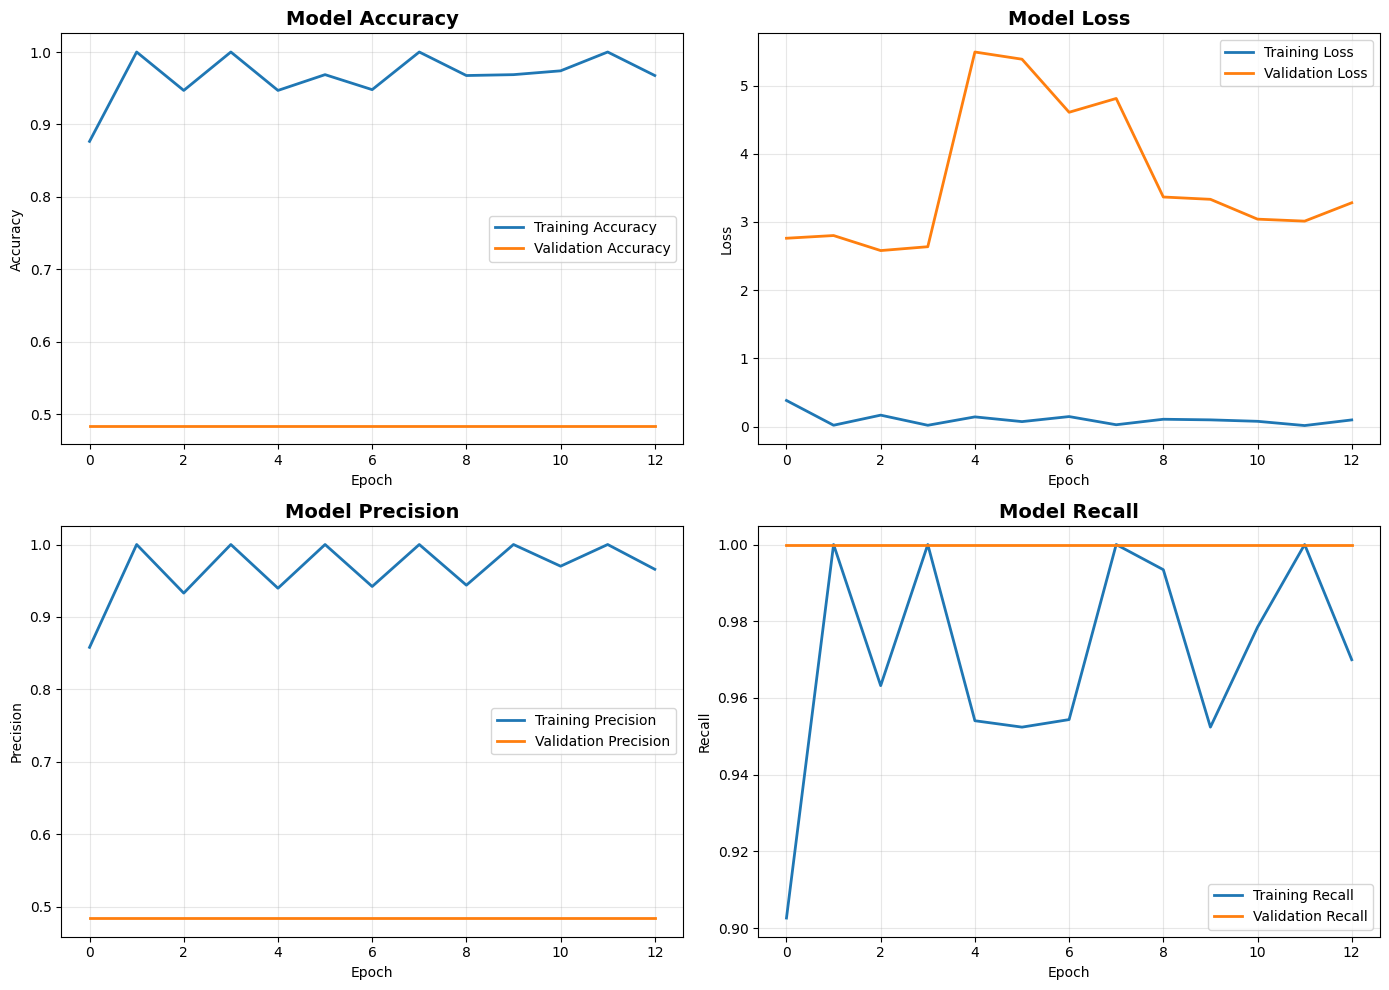


💾 Menyimpan model final...
✅ Model disimpan sebagai 'fish_classification_final_model.h5'

UJI MODEL DENGAN CONTOH GAMBAR

🔍 Contoh prediksi:
   Gambar 1: 0068ca42dd4c4a2e_fish_000323.jpg
      → Prediksi: IKAN
      → Confidence: 99.6%

   Gambar 2: non_fish_0000.jpg
      → Prediksi: IKAN
      → Confidence: 99.3%


PROSES BANGUN MODEL SELESAI!

📋 NEXT STEPS:
1. Coba model dengan gambar ikan asli dari internet
2. Jika akurasi rendah, coba:
   - Tambah lebih banyak data
   - Gunakan transfer learning (MobileNet, EfficientNet)
   - Fine-tuning hyperparameters
3. Buat laporan dengan hasil di atas

LAPORAN SINGKAT HASIL TRAINING
Dataset:
- Training samples: 956
- Validation samples: 264
- Classes: ['fish', 'non_fish']

Hasil Training:
- Epochs trained: 13
- Final Training Accuracy: 0.9675
- Final Validation Accuracy: 0.4844
- Final Validation Loss: 3.2816

Model tersimpan sebagai:
1. 'best_fish_model.h5' (model terbaik selama training)
2. 'fish_classification_final_model.h5' (model final

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import numpy as np

print("=" * 70)
print("MEMBANGUN DAN MELATIH MODEL CNN")
print("=" * 70)

# 1. Setup path dan parameter
base_dir = "./fish_crops"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")

IMG_SIZE = (150, 150)  # Sesuai dengan ukuran gambar yang sudah dibuat
BATCH_SIZE = 32
EPOCHS = 20

print(f"📁 Train directory: {train_dir}")
print(f"📁 Validation directory: {val_dir}")
print(f"📐 Input image size: {IMG_SIZE}")
print(f"📦 Batch size: {BATCH_SIZE}")
print(f"🔄 Epochs: {EPOCHS}")

# 2. Persiapan Data Generator dengan Augmentasi
print("\n🔄 Mempersiapkan data generator...")

# Augmentasi untuk data training
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalisasi pixel [0,1]
    rotation_range=20,        # Rotasi acak ±20 derajat
    width_shift_range=0.1,    # Geser horizontal acak
    height_shift_range=0.1,   # Geser vertikal acak
    shear_range=0.1,          # Shear transformation
    zoom_range=0.1,           # Zoom acak
    horizontal_flip=True,     # Flip horizontal acak
    fill_mode='nearest'       # Isi pixel yang kosong
)

# Hanya rescale untuk validation (tanpa augmentasi)
val_datagen = ImageDataGenerator(rescale=1./255)

# Buat generator untuk data training
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',      # Karena kita punya 2 kelas
    shuffle=True,
    seed=42
)

# Buat generator untuk data validation
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Tidak perlu shuffle untuk validation
)

# Cek kelas yang terdeteksi
print(f"\n✅ Classes detected: {train_generator.class_indices}")
print(f"📊 Training samples: {train_generator.samples}")
print(f"📊 Validation samples: {val_generator.samples}")

# 3. Bangun Arsitektur Model CNN
print("\n🏗️  Membangun arsitektur CNN...")

model = models.Sequential([
    # Blok Konvolusi 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),  # Regularisasi
    
    # Blok Konvolusi 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    # Blok Konvolusi 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    # Blok Konvolusi 4
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    # Flatten + Fully Connected
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),  # Dropout lebih besar untuk fully connected
    
    # Output layer (sigmoid untuk binary classification)
    layers.Dense(1, activation='sigmoid')
])

# 4. Compile Model
print("🔧 Compiling model...")
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',  # Untuk binary classification
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Tampilkan summary model
print("\n📋 Model Summary:")
model.summary()

# 5. Callbacks untuk Meningkatkan Training
print("\n⏰ Setting up callbacks...")

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Callback 1: Simpan model terbaik
checkpoint = ModelCheckpoint(
    'best_fish_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Callback 2: Early stopping jika tidak membaik
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Callback 3: Reduce learning rate jika plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

callbacks_list = [checkpoint, early_stop, reduce_lr]

# 6. Training Model
print("\n" + "=" * 70)
print("MEMULAI TRAINING MODEL...")
print("=" * 70)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    callbacks=callbacks_list,
    verbose=1
)

print("\n✅ Training selesai!")

# 7. Evaluasi Model
print("\n" + "=" * 70)
print("EVALUASI MODEL")
print("=" * 70)

# Evaluasi pada validation set
val_results = model.evaluate(val_generator, verbose=0)
print(f"📊 Validation Loss: {val_results[0]:.4f}")
print(f"📊 Validation Accuracy: {val_results[1]:.4f}")
print(f"📊 Validation Precision: {val_results[2]:.4f}")
print(f"📊 Validation Recall: {val_results[3]:.4f}")

# Hitung F1-Score
precision = val_results[2]
recall = val_results[3]
if precision + recall > 0:
    f1_score = 2 * (precision * recall) / (precision + recall)
    print(f"📊 Validation F1-Score: {f1_score:.4f}")

# 8. Visualisasi Hasil Training
print("\n📈 Visualisasi training history...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot Loss
axes[0, 1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0, 1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot Precision
axes[1, 0].plot(history.history['precision'], label='Training Precision', linewidth=2)
axes[1, 0].plot(history.history['val_precision'], label='Validation Precision', linewidth=2)
axes[1, 0].set_title('Model Precision', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot Recall
axes[1, 1].plot(history.history['recall'], label='Training Recall', linewidth=2)
axes[1, 1].plot(history.history['val_recall'], label='Validation Recall', linewidth=2)
axes[1, 1].set_title('Model Recall', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 9. Simpan Model Final
print("\n💾 Menyimpan model final...")
model.save('fish_classification_final_model.h5')
print("✅ Model disimpan sebagai 'fish_classification_final_model.h5'")

# 10. Uji Model dengan Contoh Gambar
print("\n" + "=" * 70)
print("UJI MODEL DENGAN CONTOH GAMBAR")
print("=" * 70)

def predict_image(model, img_path, img_size=(150, 150)):
    """Fungsi untuk memprediksi gambar baru"""
    from tensorflow.keras.preprocessing import image
    
    # Load dan preprocess gambar
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    
    # Prediksi
    prediction = model.predict(img_array, verbose=0)
    
    # Interpretasi
    if prediction[0] > 0.5:
        return "IKAN", float(prediction[0][0])
    else:
        return "BUKAN IKAN", float(1 - prediction[0][0])

# Uji dengan beberapa contoh
test_images = []
if os.path.exists(train_fish_dir) and len(os.listdir(train_fish_dir)) > 0:
    test_images.append(os.path.join(train_fish_dir, os.listdir(train_fish_dir)[0]))
if os.path.exists(train_non_fish_dir) and len(os.listdir(train_non_fish_dir)) > 0:
    test_images.append(os.path.join(train_non_fish_dir, os.listdir(train_non_fish_dir)[0]))

if len(test_images) > 0:
    print("\n🔍 Contoh prediksi:")
    for i, img_path in enumerate(test_images[:3]):  # Test max 3 gambar
        try:
            label, confidence = predict_image(model, img_path)
            print(f"   Gambar {i+1}: {os.path.basename(img_path)}")
            print(f"      → Prediksi: {label}")
            print(f"      → Confidence: {confidence*100:.1f}%")
            print()
        except Exception as e:
            print(f"   Error memproses {img_path}: {e}")

print("\n" + "=" * 70)
print("PROSES BANGUN MODEL SELESAI!")
print("=" * 70)
print("\n📋 NEXT STEPS:")
print("1. Coba model dengan gambar ikan asli dari internet")
print("2. Jika akurasi rendah, coba:")
print("   - Tambah lebih banyak data")
print("   - Gunakan transfer learning (MobileNet, EfficientNet)")
print("   - Fine-tuning hyperparameters")
print("3. Buat laporan dengan hasil di atas")

# 11. Buat laporan singkat
report = f"""
{'='*70}
LAPORAN SINGKAT HASIL TRAINING
{'='*70}
Dataset:
- Training samples: {train_generator.samples}
- Validation samples: {val_generator.samples}
- Classes: {list(train_generator.class_indices.keys())}

Hasil Training:
- Epochs trained: {len(history.history['loss'])}
- Final Training Accuracy: {history.history['accuracy'][-1]:.4f}
- Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}
- Final Validation Loss: {history.history['val_loss'][-1]:.4f}

Model tersimpan sebagai:
1. 'best_fish_model.h5' (model terbaik selama training)
2. 'fish_classification_final_model.h5' (model final)
{'='*70}
"""

print(report)

## Langkah 5: Evaluasi lanjutan (confusion matrix + contoh prediksi salah)

EVALUASI LANJUTAN: CONFUSION MATRIX & SAMPLE PREDIKSI

🔍 Mengumpulkan prediksi pada validation set...
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step

📋 Kelas dan indeks:
{'fish': 0, 'non_fish': 1}

📊 Confusion Matrix:
[[  0 132]
 [  0 132]]


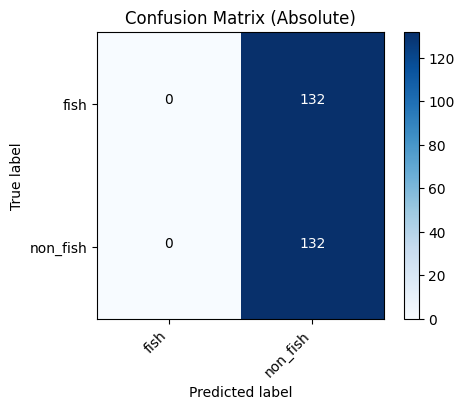

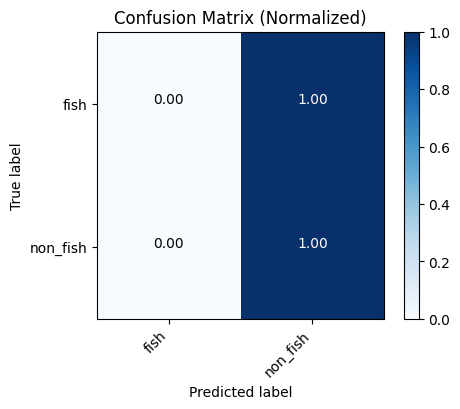


📄 Classification Report:
              precision    recall  f1-score   support

        fish       0.00      0.00      0.00       132
    non_fish       0.50      1.00      0.67       132

    accuracy                           0.50       264
   macro avg       0.25      0.50      0.33       264
weighted avg       0.25      0.50      0.33       264


🔎 Contoh beberapa prediksi yang SALAH:
Total prediksi salah: 132


d:\Semester 5 Pemrograman Mobile 5\UAS Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Semester 5 Pemrograman Mobile 5\UAS Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Semester 5 Pemrograman Mobile 5\UAS Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, 

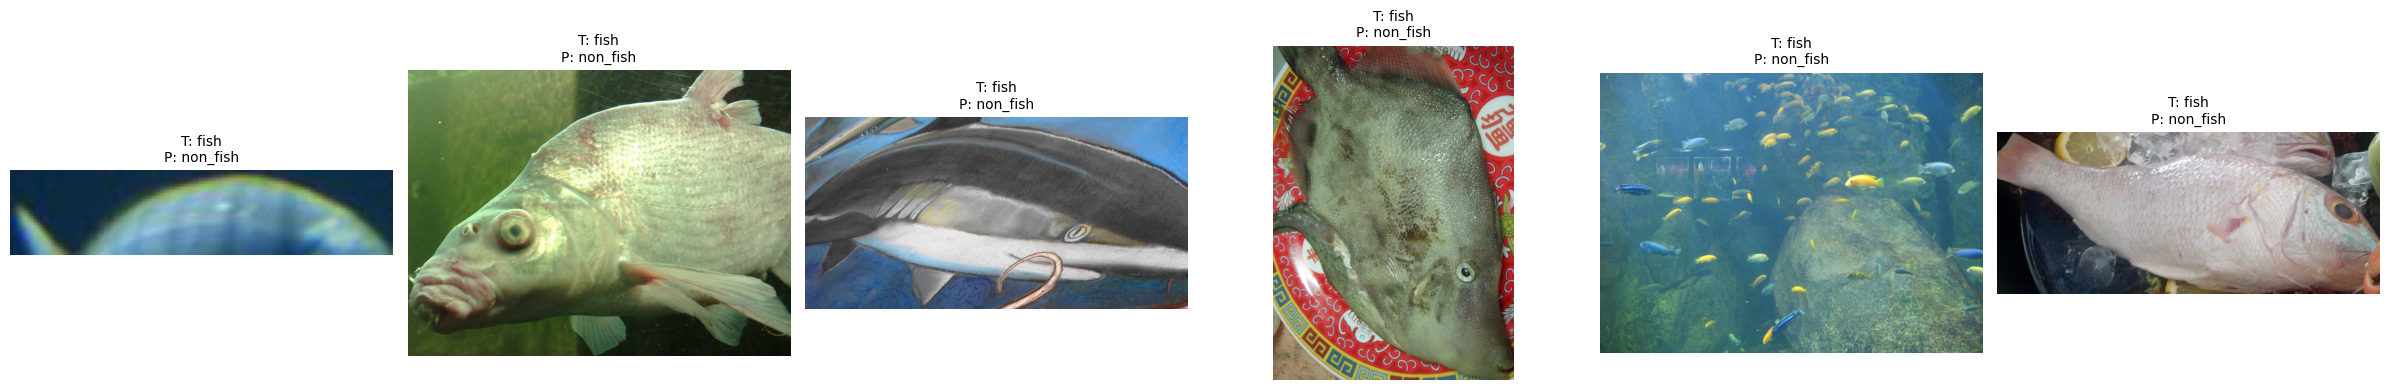


EVALUASI LANJUTAN SELESAI


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix, classification_report

print("=" * 70)
print("EVALUASI LANJUTAN: CONFUSION MATRIX & SAMPLE PREDIKSI")
print("=" * 70)

# 1. Ambil prediksi di validation set
print("\n🔍 Mengumpulkan prediksi pada validation set...")

# Pastikan generator di-reset dulu
val_generator.reset()
y_pred_probs = model.predict(val_generator, verbose=1)
y_pred = (y_pred_probs > 0.5).astype(int).ravel()

# Label ground truth dari generator
y_true = val_generator.classes

class_indices = val_generator.class_indices  # contoh: {'fish': 0, 'non_fish': 1}
idx_to_class = {v: k for k, v in class_indices.items()}
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

print("\n📋 Kelas dan indeks:")
print(class_indices)

# 2. Confusion Matrix
print("\n📊 Confusion Matrix:")

cm = confusion_matrix(y_true, y_pred)
print(cm)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Fungsi untuk plot confusion matrix yang rapi.
    Jika normalize=True, akan menampilkan dalam bentuk proporsi.
    """
    if normalize:
        cm_display = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        cm_display = cm

    plt.figure(figsize=(5, 4))
    plt.imshow(cm_display, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm_display.max() / 2.
    for i, j in itertools.product(range(cm_display.shape[0]), range(cm_display.shape[1])):
        plt.text(j, i, format(cm_display[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm_display[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot confusion matrix (angka absolut)
plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion Matrix (Absolute)')

# Plot confusion matrix (ternormalisasi)
plot_confusion_matrix(cm, classes=class_names,
                      normalize=True,
                      title='Confusion Matrix (Normalized)')

# 3. Classification report (precision, recall, f1 per kelas)
print("\n📄 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# 4. Tampilkan beberapa contoh prediksi yang salah
print("\n🔎 Contoh beberapa prediksi yang SALAH:")

# Ambil file path dari validation generator
val_filepaths = val_generator.filepaths

mis_idx = np.where(y_true != y_pred)[0]
print(f"Total prediksi salah: {len(mis_idx)}")

n_examples = min(6, len(mis_idx))

if n_examples > 0:
    fig, axes = plt.subplots(1, n_examples, figsize=(4*n_examples, 4))

    if n_examples == 1:
        axes = [axes]

    for ax, idx in zip(axes, mis_idx[:n_examples]):
        img_path = val_filepaths[idx]
        true_label = idx_to_class[y_true[idx]]
        pred_label = idx_to_class[y_pred[idx]]

        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(f"T: {true_label}\nP: {pred_label}", fontsize=10)
        ax.axis('off')
        img.close()

    plt.tight_layout()
    plt.show()
else:
    print("Model tidak memiliki prediksi salah pada validation set (setidaknya pada batch yang dihitung).")

print("\n" + "=" * 70)
print("EVALUASI LANJUTAN SELESAI")
print("=" * 70)


## Langkah 6: Menguji model dengan data REAL WORLD
### Berikut ini adalah contoh untuk memprediksi satu gambar baru dengan preprocessing yang sama (resize 150x150 dan normalisasi 1/255)

Memuat model dari: fish_classification_final_model.h5


PREDIKSI GAMBAR BARU (IKAN / BUKAN IKAN)

📁 Folder prediksi : ./fish_predict
🖼️  File gambar    : ./fish_predict\fish_sample.jpg

🔍 HASIL PREDIKSI:
   Gambar     : fish_sample.jpg
   Prediksi   : IKAN
   Confidence : 99.27%


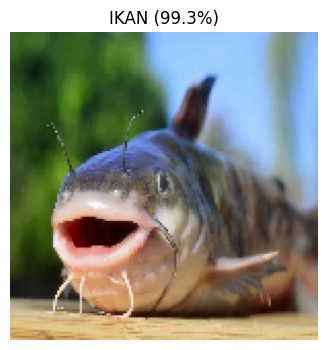

In [21]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

#* pilih salah satu model:
model_path = "fish_classification_final_model.h5"
print(f'Memuat model dari: {model_path}')
model = load_model(model_path)

print("=" * 70)
print("PREDIKSI GAMBAR BARU (IKAN / BUKAN IKAN)")
print("=" * 70)

# 1. Path folder dan file gambar yang akan diprediksi
predict_dir = "./fish_predict"
img_name = "fish_sample.jpg"   # ubah nama file sesuai kebutuhan
img_path = os.path.join(predict_dir, img_name)

print(f"\n📁 Folder prediksi : {predict_dir}")
print(f"🖼️  File gambar    : {img_path}")

if not os.path.exists(img_path):
    print("\n⚠️  Gambar tidak ditemukan. Pastikan path dan nama file sudah benar.")
else:
    # 2. Fungsi utilitas untuk prediksi satu gambar
    def predict_single_image(model, img_path, img_size=(150, 150)):
        """
        Prediksi satu gambar: mengembalikan label ('IKAN' / 'BUKAN IKAN') dan confidence.
        """
        # Load dan resize
        img = image.load_img(img_path, target_size=img_size)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # shape: (1, h, w, 3)
        img_array = img_array / 255.0                  # normalisasi sama dengan training

        # Prediksi
        prob = model.predict(img_array, verbose=0)[0][0]

        if prob > 0.5:
            label = "IKAN"
            confidence = prob
        else:
            label = "BUKAN IKAN"
            confidence = 1.0 - prob

        return label, confidence, img

    # 3. Lakukan prediksi
    label, confidence, img_loaded = predict_single_image(model, img_path, img_size=(150, 150))

    # 4. Tampilkan hasil
    print("\n🔍 HASIL PREDIKSI:")
    print(f"   Gambar     : {img_name}")
    print(f"   Prediksi   : {label}")
    print(f"   Confidence : {confidence*100:.2f}%")

    # 5. Visualisasikan gambar + label
    plt.figure(figsize=(4, 4))
    plt.imshow(img_loaded)
    plt.title(f"{label} ({confidence*100:.1f}%)")
    plt.axis('off')
    plt.show()